In [1]:
# from utils import load_dict
# from pycocotools.coco import COCO
from utils import imshow
from generator import BOTR_Generator

In [5]:
from pyramids import blend_masked_rgb, sharpen
from utils import load_dict, save_dict, filter_list, display_multiple_images
from coco_utils import load_coco_info, load_coco_image, generate_assets, coco_value_distribution, closest_sized_annotation, print_generator_status
from masking import resize_fit, create_exclusion_mask, mask_add_composite, calc_fill_percent
import numpy as np
import os
import random
import torch


In [2]:
botr = BOTR_Generator("dataset/")

loading coco assets - dataset/category_map.pickle
loading coco assets - dataset/coco_organized.pickle


filled 0.03134918212890625%
filled 0.14769363403320312%
filled 0.17623138427734375%
filled 0.4830284118652344%
! area 0.04029083251953125% smaller than minPatchArea 0.0001
filled 0.65679931640625%
filled 0.771453857421875%
filled 0.7717781066894531%
filled 0.795440673828125%
filled 0.8007774353027344%
filled 0.8190536499023438%
filled 0.9941825866699219%


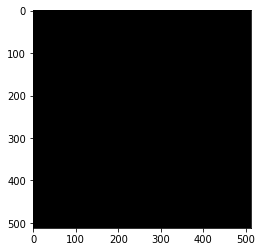

In [3]:
config = {
  # average size of each patch (1 being mean of distribution)
  'avgPatchSize' : 0.8,
  # average size variance of each patch added
  'avgPatchVariance' : 0.01,
  # minimum area of a patch added, expressed as percentage px after masking
  'minPatchArea' : 1e-4, 
  # target percentage of pixels to fill
  'targetFill' : 0.99,
  # output image size
  'outputSize' : (512, 512),
  # prevent supercategories from appearing
  'allowedCategories' : ["person", "other"],
  # choose either "stuff_ann" or "instances_ann"
  'ann_key' : "stuff_ann",
}
image = botr.generate_image(config, imageProgress=False)
imshow(image)

In [14]:
# from PIL import Image, ImageOps

# def mask_add_composite(source, mask, composite):
#     print("ASDASDASDASD")
#     masked = np.uint8(source * mask)
#     # composite[exclusionMask > 0] += np.clip(image * exclusionMask, 0, 255).astype(np.uint8)
#     composite = np.clip(composite + masked, 0, 255)

# def resize_fit(array, dims):
#     fit = Image.fromarray(array)
#     fit = np.asarray(ImageOps.fit(fit, dims))
#     if len(fit.shape) == 2:
#       fit = np.expand_dims(fit, -1)
#     return fit

In [6]:
config = {
  # average size of each patch (1 being mean of distribution)
  'avgPatchSize' : 0.8,
  # average size variance of each patch added
  'avgPatchVariance' : 0.01,
  # minimum area of a patch added, expressed as percentage px after masking
  'minPatchArea' : 1e-4, 
  # target percentage of pixels to fill
  'targetFill' : 0.99,
  # output image size
  'outputSize' : (512, 512),
  # prevent supercategories from appearing
  'allowedCategories' : ["person", "other"],
  # choose either "stuff_ann" or "instances_ann"
  'ann_key' : "stuff_ann",
  # prevent supercategories from appearing
  'disallowed_catg' : ["person", "other"],
  # choose either "stuff_ann" or "instances_ann"
}

composite = np.zeros((config["outputSize"][0], config["outputSize"][1],3), dtype=np.uint8)
compositeMask = np.zeros((config["outputSize"][0], config["outputSize"][1], 1), dtype=np.uint8)

attributes = botr.gen_attribute_dict()
totalArea = config['outputSize'][0]*config['outputSize'][1]

px_filled = 0

while px_filled < config['targetFill']:
  randCoco = botr.get_coco_example()
  annList = randCoco[config['ann_key']]
  annList = botr.filter_ann_categories(annList, config["allowedCategories"])
  
  if len(annList) == 0:
    print(f'! len of valid annotations is 0, skipping...')
    continue

  # randomly select a coco annotation with
  # gaussian probability of selecting a given sized one
  chosenAnn = botr.gaussian_select_patch(
    annList=annList,
    annKey=config['ann_key'],
    avgSize=config['avgPatchSize'],
    sizeVariance=config['avgPatchVariance'])

  # obtain mask of the coco annotation
  objectMask = botr.get_mask(chosenAnn)
  # resize the mask to fit within bounds of output size
  # here we can choose to apply other transformations if we want
  objectMask = resize_fit(objectMask, config['outputSize'])
  
  print(f'OBJ SHAPE {objectMask.shape} COMP SHAPE {compositeMask.shape}')
  exclusionMask = create_exclusion_mask(objectMask, compositeMask)

  areaPercent = calc_fill_percent(objectMask, totalArea)
  
  if not exclusionMask.any() or areaPercent < config['minPatchArea']:
    print(f'! area {areaPercent}% smaller than minPatchArea {config["minPatchArea"]}')
    continue

  image = load_coco_image(randCoco['filename'], fit=config['outputSize'])

  # add the masked content on to the composite (inplace modify composite)
  composite = mask_add_composite(image, exclusionMask, composite)

  # generate composite mask
  # compositeMask = np.clip(composite, 0, 1)
  compositeMask = np.logical_or(exclusionMask, compositeMask).astype(np.uint8)
  
  # if imageProgress:
    # display_multiple_images(
    #   [image, objectMask, compositeMask, exclusionMask, composite], 
    #   ["original img", "chosen mask", "composite_mask", "exclusion mask", "composite"])

  px_filled = calc_fill_percent(compositeMask, totalArea)

  categName = botr.ann_category_name(chosenAnn)
  attributes[categName] += areaPercent
  
  # include which objects are filled
  attributes['text_metadata']['objects'].append(categName)
  attributes['text_metadata']['objects'].append(randCoco['caption'])
  # print_generator_status(attributes, px_filled)

OBJ SHAPE (512, 512, 1) COMP SHAPE (512, 512, 1)
OBJ SHAPE (512, 512, 1) COMP SHAPE (512, 512, 1)
OBJ SHAPE (512, 512, 1) COMP SHAPE (512, 512, 1)
OBJ SHAPE (512, 512, 1) COMP SHAPE (512, 512, 1)
OBJ SHAPE (512, 512, 1) COMP SHAPE (512, 512, 1)
OBJ SHAPE (512, 512, 1) COMP SHAPE (512, 512, 1)
OBJ SHAPE (512, 512, 1) COMP SHAPE (512, 512, 1)
OBJ SHAPE (512, 512, 1) COMP SHAPE (512, 512, 1)
OBJ SHAPE (512, 512, 1) COMP SHAPE (512, 512, 1)
OBJ SHAPE (512, 512, 1) COMP SHAPE (512, 512, 1)
OBJ SHAPE (512, 512, 1) COMP SHAPE (512, 512, 1)
OBJ SHAPE (512, 512, 1) COMP SHAPE (512, 512, 1)
OBJ SHAPE (512, 512, 1) COMP SHAPE (512, 512, 1)
! area 0.07799911499023438% smaller than minPatchArea 0.0001
OBJ SHAPE (512, 512, 1) COMP SHAPE (512, 512, 1)
OBJ SHAPE (512, 512, 1) COMP SHAPE (512, 512, 1)
! area 0.00392913818359375% smaller than minPatchArea 0.0001
OBJ SHAPE (512, 512, 1) COMP SHAPE (512, 512, 1)
OBJ SHAPE (512, 512, 1) COMP SHAPE (512, 512, 1)
! area 0.17273330688476562% smaller than minP

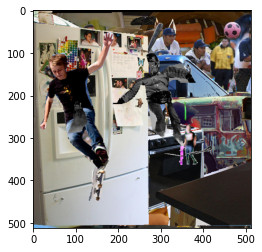

In [7]:
import matplotlib.pyplot as plt
plt.imshow(composite)
plt.show()

In [25]:
from PIL import Image
def mask_add_composite(source, mask, composite):
    # print(f'SOURCE {source.shape} {source.dtype} MASK {mask.shape} {mask.dtype} COMP {composite.shape} {composite.dtype}')
    
    # source = Image.fromarray(source)
    # mask = Image.fromarray(mask).convert("RGB")
    # composite = Image.fromarray(composite)
    
    # composite = Image.composite(source, composite, mask)
    mask = np.clip(mask, 0, 1)
    masked = np.uint8(source * mask)
    # composite[exclusionMask > 0] += np.clip(image * exclusionMask, 0, 255).astype(np.uint8)
    composite = np.clip(composite + masked, 0, 255)
    return composite
